This file plots out the results from Snakefile Run 2
(samples 8; methods: linreg, boosting, elastic, forest;
features: single, forest, string, all)

Note the boosting had larger steps 0.1 and fewer n_estimators (200).
There are fewer alpha hyperparameter values to optimize for in ElasticNetCV
The results are output in a dictionary (model, metrics)

In [1]:
data_dir = '/Volumes/Ginkgo_Data/Data/2021-11_CPTACTrainedModels/out2'

In [2]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from predict_protein import download_cptac, select_features, train_model
from predict_protein import utils

get_dataframe = utils.get_dataframe

def get_median_corr(path):
    return np.median(get_dataframe(path)['corr_test'])

def plot_corr(path):

    res = get_dataframe(path)

    res['id'] = res.index
    df_ = pd.wide_to_long(res, ['corr'], i='id', j='set', sep='_', suffix=r'\w+')

    df_g = df_.groupby('set')['corr'].agg(['mean', 'median'])

    g = sns.displot(
        data=df_, x='corr',
        col='set',
        facet_kws=dict(sharey=False, sharex=False)
    )

    # extract and flatten the axes from the figure
    axes = g.axes.flatten()

    # iterate through each axes
    for ax in axes:
        # extract the species name
        spec = ax.get_title().split(' = ')[1]

        # select the data for the species
        data = df_g.loc[spec, :]

        ax.text(x=data['median'], y=2, s='median: ' + str(np.round(data['median'], 3)))
        # plot the lines
        ax.axvline(x=data['median'], c='orange', ls='--', lw=2.5)

    g.savefig(os.path.splitext(path)[0] + '.pdf')

    return g


cptac warning: Your version of cptac (1.0.0rc1) is out-of-date. Latest is 1.0.0. Please run 'pip install --upgrade cptac' to update it. (/Users/edwardlau/PythonProjects/CPTAC_Protein/predict_protein/download_cptac.py, line 5)


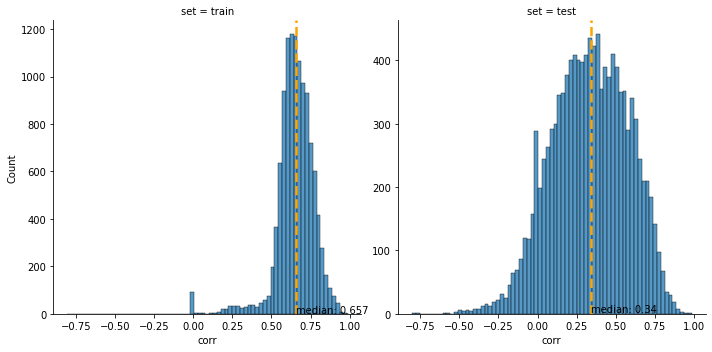

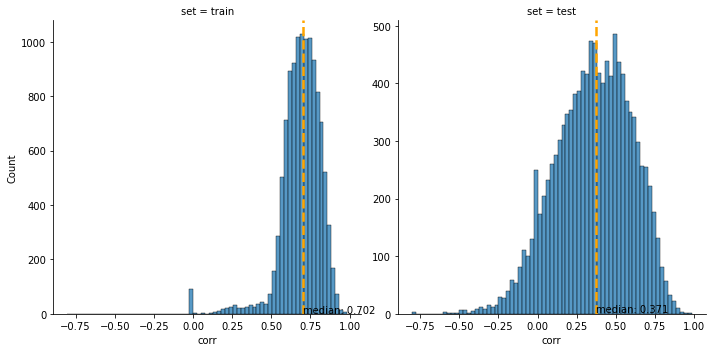

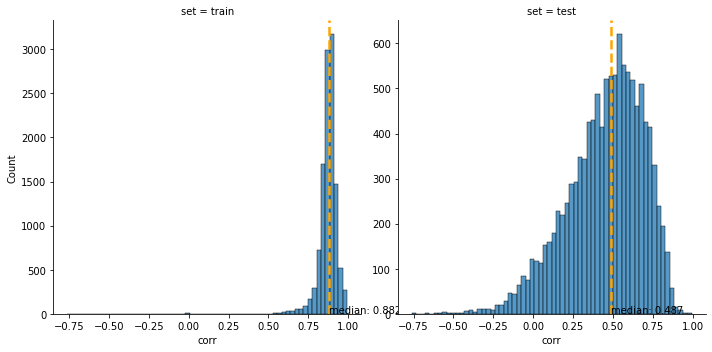

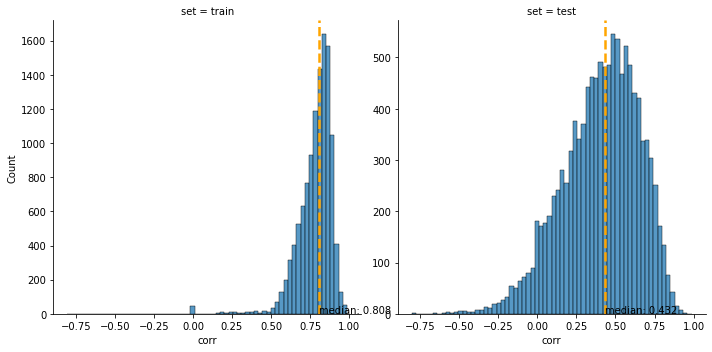

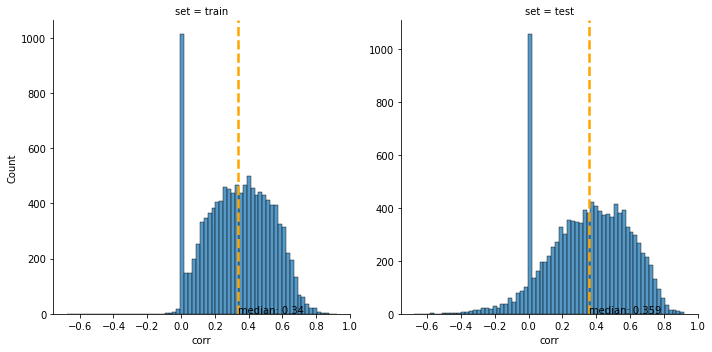

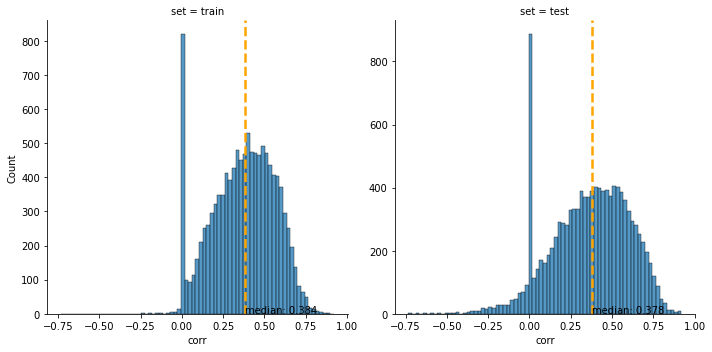

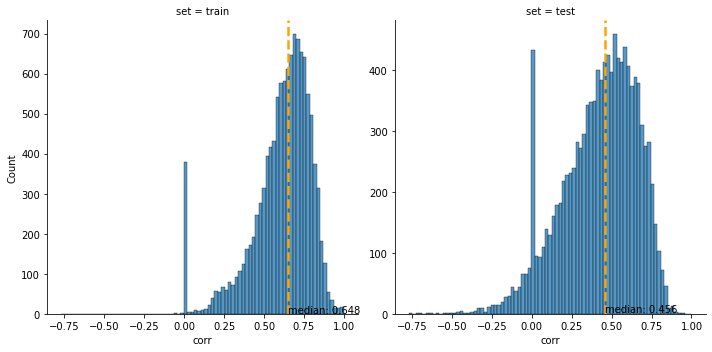

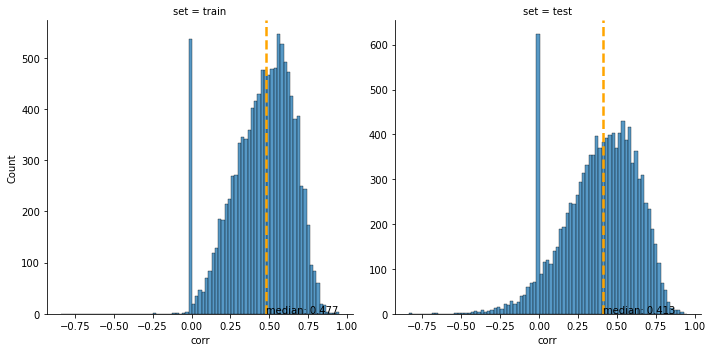

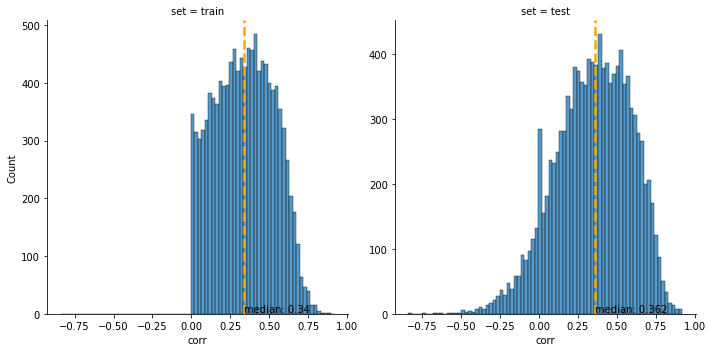

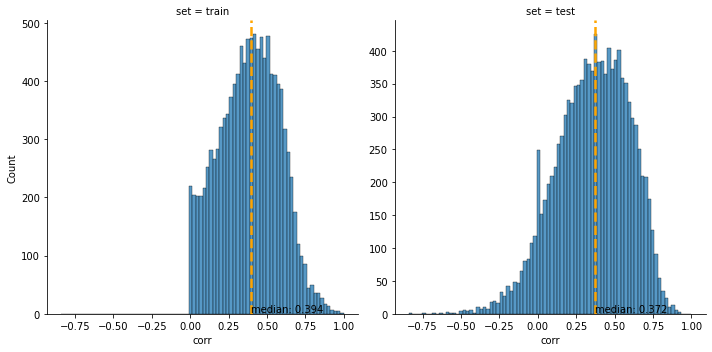

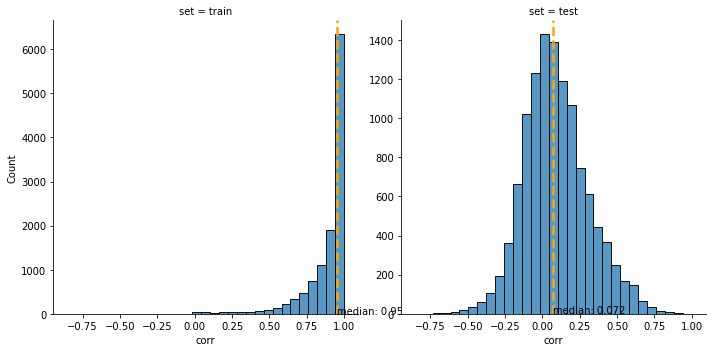

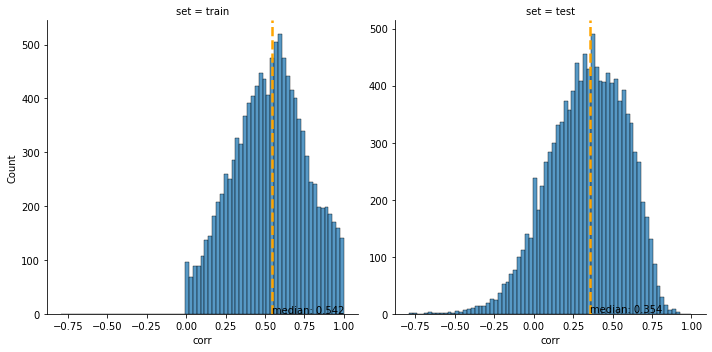

In [3]:
# for tumor in ['tumor2', 'tumor5', 'tumor8']:
#     for method in ['linreg', 'elastic', 'forest', 'boosting']:
#         for feature in ['single', 'corum', 'string']:
#             plot_corr(f'../out2/{tumor}_{method}_{feature}.p')


for tumor in ['tumor3']:
    for method in ['forest', 'elastic', 'linreg']:
        for feature in ['single', 'corum', 'string', 'stringhi']:
            fname =  f'{tumor}_{method}_{feature}'
            plot_corr(os.path.join(data_dir, f'{fname}.p'))

In [4]:

for tumor in ['tumor2', 'tumor3', 'tumor4', 'tumor5', 'tumor6', 'tumor7', 'tumor8',]:
    for method in ['forest', 'elastic', 'linreg']:
        for feature in ['single', 'corum', 'string', 'stringhi', 'all']:
            fname =  f'{tumor}_{method}_{feature}'
            if not os.path.exists(os.path.join(data_dir,f'{fname}_metrics.csv')):
                df__ = get_dataframe(os.path.join(data_dir, f'{fname}.p'))
                df2 = df__.describe().copy()
                df2['tumor'] = tumor
                df2['method'] = method
                df2['feature'] = feature
                df2['measure'] = df2.index
                df2.to_csv(os.path.join(data_dir, f'{fname}_metrics.csv'))


In [5]:
all_metrics = []

for tumor in [ 'tumor2', 'tumor3', 'tumor4', 'tumor5', 'tumor6', 'tumor7', 'tumor8', ]:
    for method in ['forest', 'elastic', 'linreg']:
        for feature in ['single', 'corum', 'string', 'stringhi', 'all']:
            fname =  f'{tumor}_{method}_{feature}'
            read_df = pd.read_csv(os.path.join(data_dir, f'{fname}_metrics.csv'))
            all_metrics.append(read_df)
metrics_df = pd.concat(all_metrics, ignore_index=True)


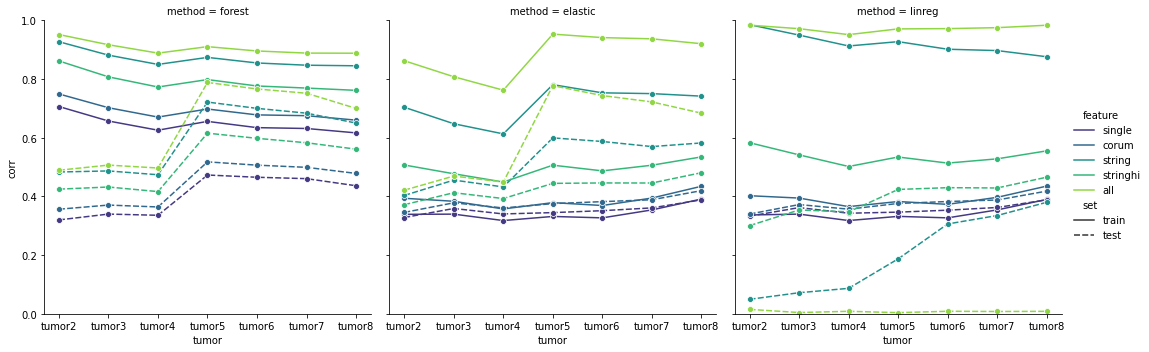

In [6]:
metrics_df
medians = metrics_df[metrics_df['measure'] == '50%'].copy()
medians2 = pd.wide_to_long(medians, 'corr', i=['tumor', 'method', 'feature'], j='set', sep='_', suffix='\\w+')

g = sns.relplot(data=medians2,
                x='tumor',
                y='corr',
                col='method',
                col_wrap=3,
                palette='viridis',
                hue='feature',
                style='set',
                kind='line',
                marker='o',
                )
g.set(ylim=(0, 1))
g.savefig('Metrics.png')